#### 8

In [1]:
library(forecast)
library(ggplot2)
library(dplyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
# library(doParallel)
library(doMC)
options(cores = 10)
registerDoMC()
require(svMisc)

Loading required package: foreach
Loading required package: iterators
Loading required package: parallel
Loading required package: svMisc

Attaching package: ‘svMisc’

The following object is masked from ‘package:utils’:

    ?



In [3]:
library(data.table)
library(hts)  


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [4]:
df_eu  <-  read.csv(file="../data_hts/hts_eu_a10.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [5]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [6]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

var_arpdq   <-  c(3,1,1)
var_sarpdq   <-  c(2,1,1)
var_drift   <-  FALSE
var_constant   <-  FALSE
var_ets  <- "MMM"
var_damped  <- FALSE

var_char  <-  c(2,1)

In [7]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data, characters = var_char)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
# allts <- aggts(gts_train)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

In [9]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    allts <- aggts(gts_train)
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- ets(msts(allts[,j], seasonal.periods = var_freq), model=var_ets, damped = var_damped , lambda=NULL)
        
    }
    
     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5, characters = var_char)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2922.901 2972.497 2966.059 3035.703 2946.833 2996.862 2990.408 3060.631
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60
Hierarchical Time Series 
3 Levels 
Number of nodes at each level: 1 28 280 
Total number of series: 309 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2992.821 3046.936 3047.040 3112.665 3028.813 3083.576 3083.715 3150.126
Hierarchical Time Series 
3 Le

In [10]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [11]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [12]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [13]:
df_acc

ME,RMSE,MAPE,Iteration
45.86593,47.56589,1.5087533,1
29.90171,47.91594,1.1792530,5
81.03448,95.24566,2.4632037,9
54.66117,65.14837,1.6993746,13
-98.92933,104.80911,2.9062201,17
14.96312,27.13281,0.6508362,20


In [14]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3333.898 3418.668 3439.465 3525.368 3451.498 3539.258 3560.788 3649.722

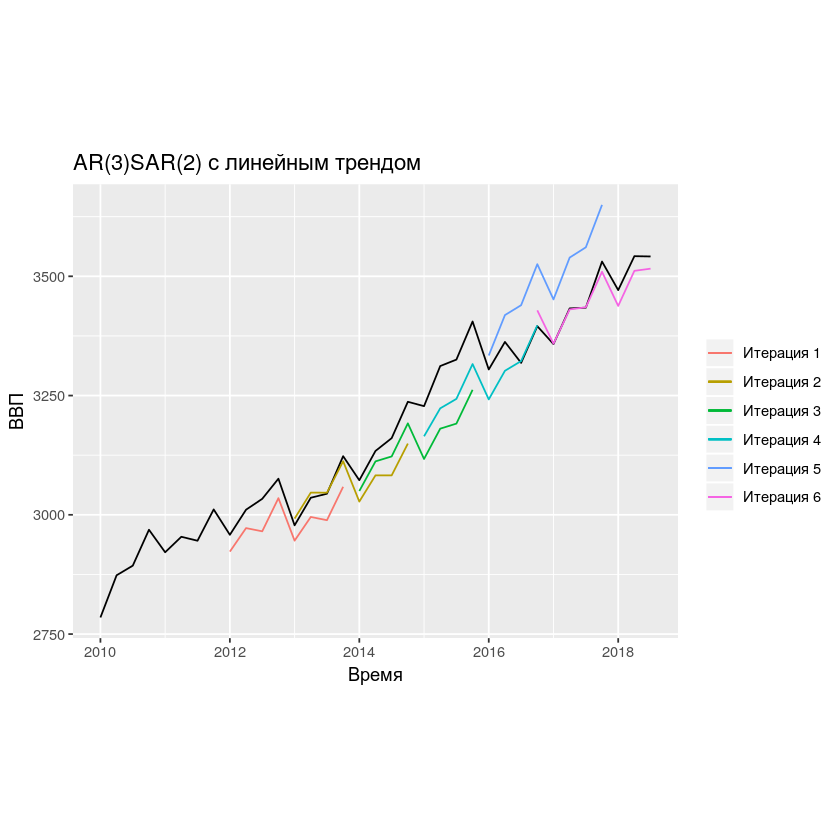

In [15]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [16]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
21.249512 64.636297  1.734607 10.833333

In [17]:
df_mean_acc <- readRDS("df_mean_acc.rds")
rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [18]:
df_mean_acc[2,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.05969,196.2254,8256.353
3 level,64.63630,NA,NA
2 level (state),NA,NA,NA
2 level (type),NA,NA,NA
2 level (clusetered),NA,NA,NA


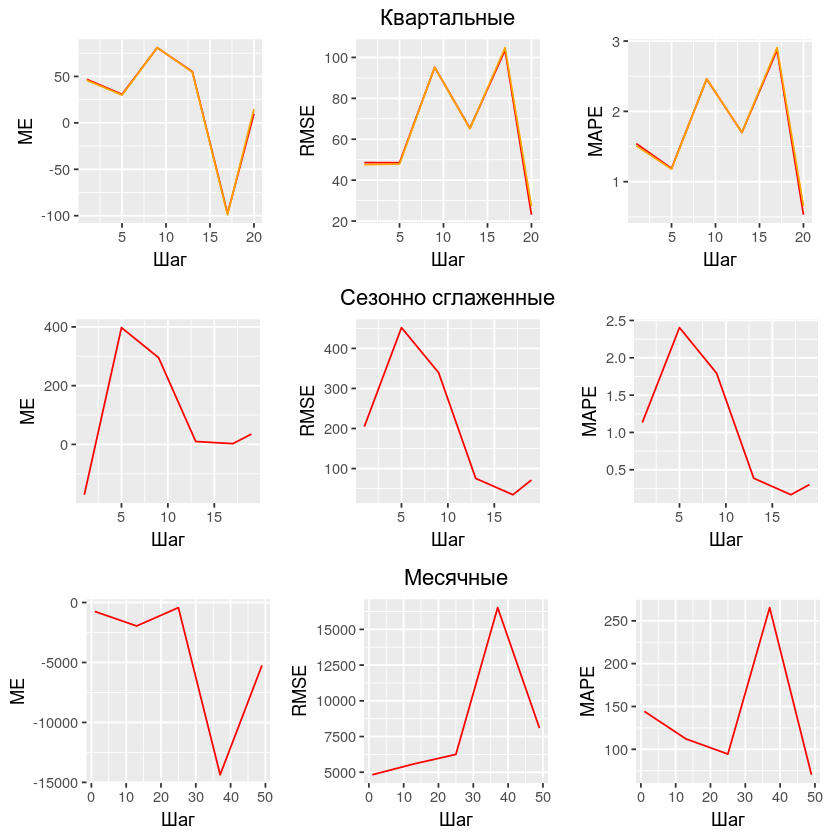

In [19]:
# Basic line plot with points

plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'orange'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 state

In [20]:
df_eu  <-  read.csv(file="../clustering/hts_eu_a10_state.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [21]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [22]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

# var_arpdq   <-  c(3,0,0)
# var_sarpdq   <-  c(2,0,0)
# var_char  <-  c(2,1)

In [23]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
# allts <- aggts(y)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [24]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- ets(msts(allts[,j], seasonal.periods = var_freq), model=var_ets, damped = var_damped , lambda=NULL)
        
    }
    

     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2922.829 2972.388 2965.913 3035.540 2946.611 2996.598 2990.100 3060.301
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2992.739 3046.840 3046.907 3112.525 3028.601 3083.345 3083.440 3149.840
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 53 
End = 60 
Frequency = 1 
[1] 2977.965 3035.742 3044.227 3122.905 3072.484 3133.907 3160.757 3236.918
[1]  9 56 57 64


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3049.544 3111.815 3122.294 3191.627 3116.841 3180.482 3191.217 3262.082
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 57 
End = 64 
Frequency = 1 
[1] 3072.484 3133.907 3160.757 3236.918 3227.776 3311.839 3325.372 3405.251
|[1] 13 60 61 68


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3164.391 3223.326 3243.267 3316.206 3242.307 3302.694 3323.168 3397.902
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 61 
End = 68 
Frequency = 1 
[1] 3227.776 3311.839 3325.372 3405.251 3304.666 3362.395 3318.470 3395.389
|[1] 17 64 65 72


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3334.272 3418.827 3440.071 3525.956 3452.810 3540.390 3562.460 3651.419
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 65 
End = 72 
Frequency = 1 
[1] 3304.666 3362.395 3318.470 3395.389 3357.919 3432.684 3434.182 3530.894
[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3426.554 3356.000 3426.591 3430.304 3503.921 3431.922 3504.404 3508.360
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 28 
Total number of series: 29 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 68 
End = 75 
Frequency = 1 
[1] 3395.389 3357.919 3432.684 3434.182 3530.894 3471.013 3542.181 3541.582


In [25]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [26]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [27]:
df_acc

ME,RMSE,MAPE,Iteration
46.06781,47.76941,1.5153831,1
30.08355,48.08731,1.1825047,5
81.05035,95.26364,2.4636870,9
54.73696,65.19538,1.6998044,13
-98.70096,104.57192,2.8995466,17
14.72361,26.95752,0.6450206,20


In [28]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3333.898 3418.668 3439.465 3525.368 3451.498 3539.258 3560.788 3649.722

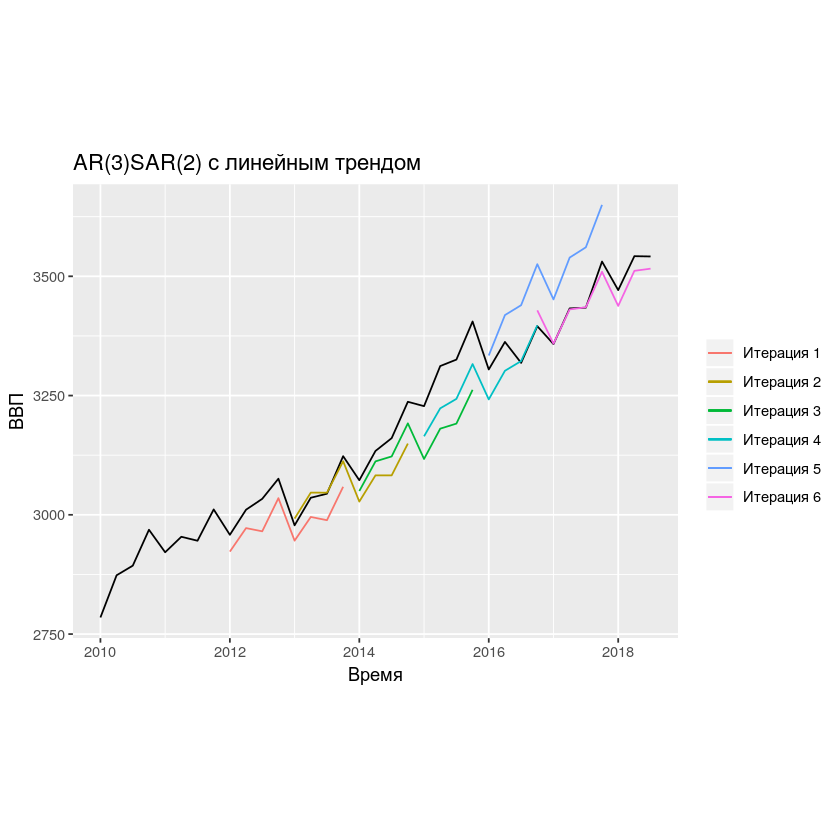

In [29]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [30]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
21.326886 64.640863  1.734324 10.833333

In [31]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [32]:
df_mean_acc[3,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.05969,196.2254,8256.353
3 level,64.63630,NA,NA
2 level (state),64.64086,NA,NA
2 level (type),NA,NA,NA
2 level (clusetered),NA,NA,NA


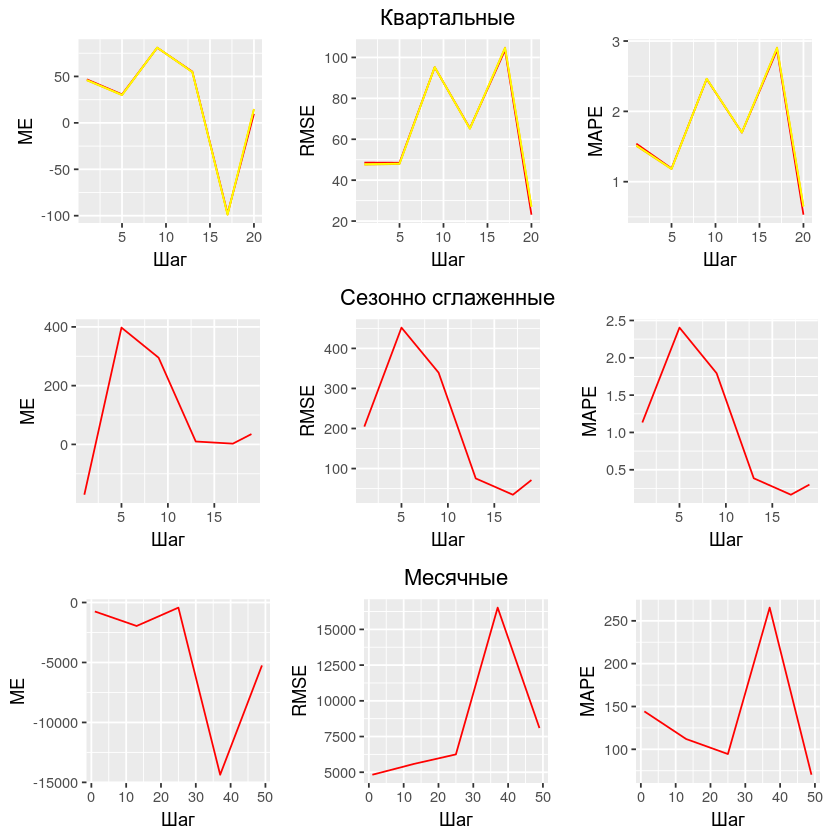

In [33]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'yellow'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 type

In [34]:
df_eu  <-  read.csv(file="../clustering/hts_eu_a10_type.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [35]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [36]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0

# var_arpdq   <-  c(3,0,0)
# var_sarpdq   <-  c(2,0,0)
# var_char  <-  c(2,1)

In [37]:
75-69

[1] 6

In [38]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
allts <- aggts(gts_train)
allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [39]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- ets(msts(allts[,j], seasonal.periods = var_freq), model=var_ets, damped = var_damped , lambda=NULL)
        
    }
    

     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2924.160 2973.870 2967.921 3038.085 2950.195 3000.346 2994.353 3065.133
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2994.369 3049.142 3049.948 3116.144 3033.600 3089.064 3089.900 3156.985
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 53 
End = 60 
Frequency = 1 
[1] 2977.965 3035.742 3044.227 3122.905 3072.484 3133.907 3160.757 3236.918
[1]  9 56 57 64


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3049.192 3111.013 3121.043 3190.585 3115.409 3178.564 3188.825 3259.861
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 57 
End = 64 
Frequency = 1 
[1] 3072.484 3133.907 3160.757 3236.918 3227.776 3311.839 3325.372 3405.251
|[1] 13 60 61 68


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3164.458 3223.583 3242.961 3316.236 3242.035 3302.595 3322.440 3397.517
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 61 
End = 68 
Frequency = 1 
[1] 3227.776 3311.839 3325.372 3405.251 3304.666 3362.395 3318.470 3395.389
|[1] 17 64 65 72


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3334.437 3418.650 3439.067 3524.616 3451.377 3538.586 3559.735 3648.308
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 65 
End = 72 
Frequency = 1 
[1] 3304.666 3362.395 3318.470 3395.389 3357.919 3432.684 3434.182 3530.894
[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3428.842 3357.821 3428.980 3431.716 3508.460 3435.849 3508.631 3511.436
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 10 
Total number of series: 11 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 68 
End = 75 
Frequency = 1 
[1] 3395.389 3357.919 3432.684 3434.182 3530.894 3471.013 3542.181 3541.582


In [40]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [41]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [42]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [43]:
df_acc

ME,RMSE,MAPE,Iteration
43.09490,44.82091,1.4177058,1
25.71923,43.96021,1.1005369,5
82.47666,96.80053,2.5072204,9
54.91646,65.22310,1.6968556,13
-97.27206,102.95227,2.8579538,17
11.76378,24.78197,0.5768399,20


In [44]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3333.898 3418.668 3439.465 3525.368 3451.498 3539.258 3560.788 3649.722

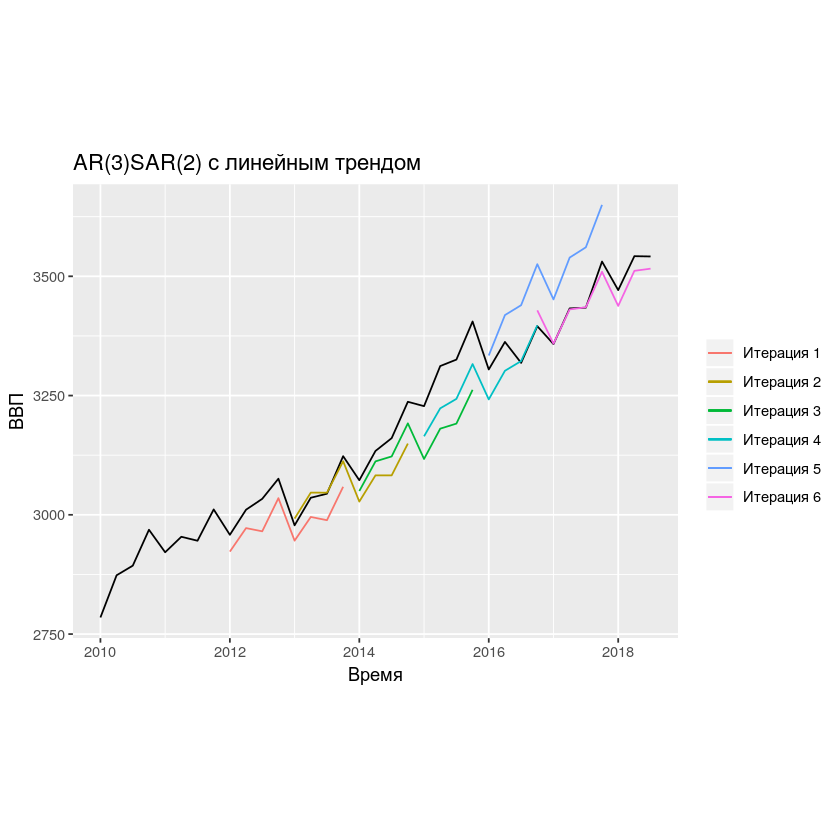

In [45]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [46]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
20.116494 63.089834  1.692852 10.833333

In [47]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [48]:
df_mean_acc[4,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.05969,196.2254,8256.353
3 level,64.63630,NA,NA
2 level (state),64.64086,NA,NA
2 level (type),63.08983,NA,NA
2 level (clusetered),NA,NA,NA


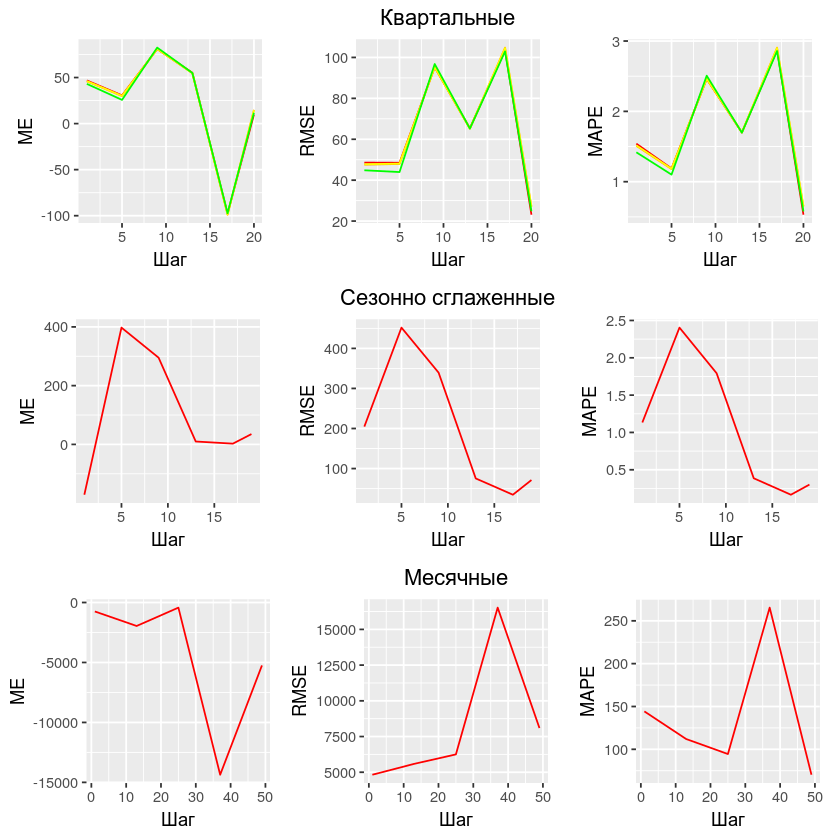

In [49]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'green'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

#### 2 clust

In [50]:
df_eu  <-  read.csv(file="../clustering/hts_eu_a10_clust.csv", header=TRUE, sep=",", row.names =1 )
df_eu  <-  df_eu/1000
var_freq  <- 4    
var_start_year  <- 2000   
gdp_agg <- df_eu_sums <-  rowSums(df_eu)
gdp_agg  <- ts(gdp_agg, frequency = var_freq, start = var_start_year) 

In [51]:
var_h  <- 8
var_window  <-  48 - 1
var_topup  <-  1
var_iter   <- (length(gdp_agg)+var_topup)/var_freq-(var_window+1)/var_freq-2

In [52]:
# var_allornot  <- var_freq
var_allornot  <- 1
# var_shift  <-  var_topup
var_shift  <-  0



In [53]:
df_eu  <-  as.data.table(df_eu)
data  <-  df_eu
y  <-  hts(data)
s  <-  smatrix(y)
# gts_train  <- window(y, start=20, end=67)
# gts_test  <- window(y, start=68, end=75)
# allts <- aggts(gts_train)
# allf <- matrix(, nrow=var_h, ncol=ncol(allts))

Since argument characters are not specified, the default labelling system is used.


In [54]:
l <- ac <- m_top  <- l_test  <-  l_top  <-  list()

df_ac  <-  data.frame(matrix(ncol = 0, nrow = 0))

k  <- 0

for (i in 0:(var_iter*var_allornot - var_shift)){
    k  <-  k+1
    st_year  <-  var_start_year + i/var_allornot
    train_start  <- st_year 
    train_end  <- st_year + 1/var_freq*(var_window)
    test_start  <- st_year + 1/var_freq*(var_window+1) 
    test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
    dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1
    
    train_start  <- dates[1] 
    train_end  <- dates[2]
    test_start  <- dates[3]
    test_end  <- dates[4]
    
    print(c(train_start, train_end, test_start, test_end))
    
    
    if (i == 0){
        gts_train <- window(y, end=train_end)    
    }
    else{
        if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
            gts_train <- window(y, start=dates[5], end=dates[6])
        }else{
            gts_train <- window(y, start=train_start, end=train_end)
    }}
    
    if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
        gts_test <- window(y, start=dates[7])
      
    }else{  
     gts_test <- window(y, start=test_start, end=test_end)
          
    }
    
    
    allts <- aggts(gts_train)
    
    
    ms <-  foreach(j=1:ncol(allts)) %dopar% {
        model  <- ets(msts(allts[,j], seasonal.periods = var_freq), model=var_ets, damped = var_damped , lambda=NULL)
        
    }
    

     
        
    allf <- matrix(, nrow=var_h, ncol=ncol(allts))
        
    
    for(j in 1:ncol(allts)){  
    allf[,j] <- forecast(ms[[j]], h=var_h)$mean
    
    
    }

    
    allf <- ts(allf)
    colnames(allf)  <-  colnames(allts)  
    g <- get_nodes(gts_train)
    y.f <- combinef(allf, nodes = g)
    forecasts_7  <- y.f[[1]]
    colnames(forecasts_7)  <- colnames(y[[1]])
    data_f5  <- rbind(gts_train[[1]], forecasts_7)
    y_f5  <- hts(data_f5)
        
#     if (i == 4){
#         gts_forecasts_7 <- window(y_f5, start=test_start)}
#     else{
#     gts_forecasts_7 <- window(y_f5, start=test_start, end=test_end)
# #     }

#     if ((var_shift == 0) & (i == var_iter*var_allornot - var_shift)){
#         gts_forecasts_7 <- window(y_f5, start=dates[7])
      
#     }else{  
     gts_forecasts_7 <- window(y_f5, start=dim(y_f5[[1]])[1]-var_h+1)
          
#     }
         
    print(gts_forecasts_7)
    print(gts_test)
            
    
    l[[k]]  <- allf

    ac[[k]]  <-  accuracy.gts(gts_forecasts_7, gts_test)[, 1] 

    progress(i, progress.bar = TRUE)
            
    }

[1]  1 48 49 56


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2923.236 2972.991 2966.534 3036.373 2947.611 2997.790 2991.302 3061.733
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2958.070 3010.722 3033.490 3075.700 2977.965 3035.742 3044.227 3122.905
          0%---------25%---------50%---------75%--------100%
Progress: [1]  5 52 53 60


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 2992.938 3047.492 3047.647 3113.791 3030.194 3085.421 3085.656 3152.610
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 53 
End = 60 
Frequency = 1 
[1] 2977.965 3035.742 3044.227 3122.905 3072.484 3133.907 3160.757 3236.918
[1]  9 56 57 64


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3049.888 3112.037 3122.433 3191.863 3117.282 3180.796 3191.460 3262.405
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 57 
End = 64 
Frequency = 1 
[1] 3072.484 3133.907 3160.757 3236.918 3227.776 3311.839 3325.372 3405.251
|[1] 13 60 61 68


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3165.062 3224.324 3244.344 3317.675 3244.089 3304.815 3325.404 3400.545
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 61 
End = 68 
Frequency = 1 
[1] 3227.776 3311.839 3325.372 3405.251 3304.666 3362.395 3318.470 3395.389
|[1] 17 64 65 72


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3334.274 3418.741 3439.802 3525.636 3452.310 3539.755 3561.622 3650.470
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 65 
End = 72 
Frequency = 1 
[1] 3304.666 3362.395 3318.470 3395.389 3357.919 3432.684 3434.182 3530.894
[1] 21 68 69 76


Since argument characters are not specified, the default labelling system is used.


Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 49 
End = 56 
Frequency = 1 
[1] 3426.871 3356.305 3427.583 3431.408 3505.542 3433.378 3506.424 3510.382
Hierarchical Time Series 
2 Levels 
Number of nodes at each level: 1 25 
Total number of series: 26 
Number of observations per series: 8 
Top level series: 
Time Series:
Start = 68 
End = 75 
Frequency = 1 
[1] 3395.389 3357.919 3432.684 3434.182 3530.894 3471.013 3542.181 3541.582


In [55]:
var_acc_metrics  <-  c(1,2,4)
df_acc_test  <- ac[[1]][var_acc_metrics]
for (i in ac[2:length(ac)]){
    x  <-  i[var_acc_metrics]
    df_acc_test   <-  cbind(df_acc_test, x)
}
df_acc_test  <- t(df_acc_test)
df_acc_test  <-  as.data.frame(df_acc_test)
row.names(df_acc_test)  <-  seq(1,length(ac))
df_acc  <- df_acc_test
df_acc  <-  cbind(df_acc, seq(1, length(ac)))
colnames(df_acc)[length(var_acc_metrics)+1]  <-  'Iteration'

In [56]:
df_acc$Iteration  <-  df_acc$Iteration*var_freq-(var_freq-1)

In [57]:
df_acc$Iteration[length(df_acc$Iteration)]  <-   df_acc$Iteration[length(df_acc$Iteration)] - var_topup

In [58]:
df_acc

ME,RMSE,MAPE,Iteration
45.15634,46.86620,1.4854348,1
28.64465,46.56239,1.1497732,5
80.76733,95.00386,2.4549408,9
53.11242,64.11577,1.6875274,13
-98.25159,104.07378,2.8864598,17
13.49401,25.83270,0.6121749,20


In [59]:
l[[5]][,1]

Time Series:
Start = 1 
End = 8 
Frequency = 1 
[1] 3333.898 3418.668 3439.465 3525.368 3451.498 3539.258 3560.788 3649.722

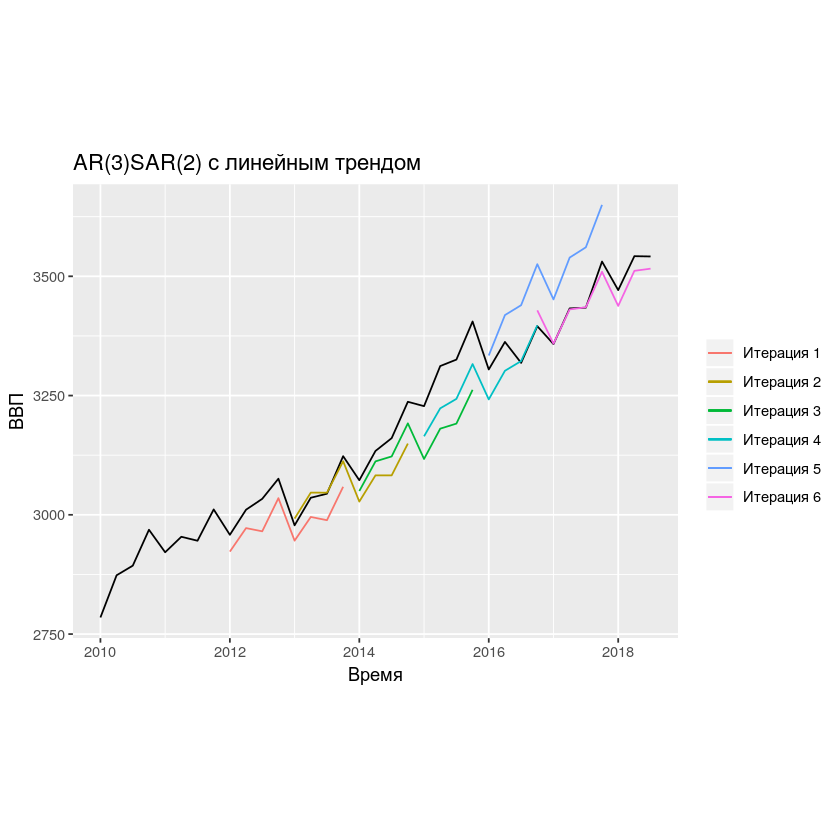

In [60]:
plot_forecasts  <-  autoplot(window(gdp_agg, start=2010))+
    xlab("Время") + ylab('ВВП') +
    ggtitle("AR(3)SAR(2) с линейным трендом") +
    guides(colour=guide_legend(title=" ")) +
    theme(aspect.ratio = 0.75)

# for (i in 0:(var_iter*var_allornot - var_shift)){
#     k  <-  k+1
#     st_year  <-  var_start_year + i/var_allornot
#     train_start  <- st_year 
#     train_end  <- st_year + 1/var_freq*(var_window)
#     test_start  <- st_year + 1/var_freq*(var_window+1) 
#     test_end  <-  st_year + 1/var_freq*(var_window+var_h)
    
#     dates  <-  (c(train_start, train_end, test_start, test_end, train_start-var_topup/var_freq, train_end-var_topup/var_freq, test_start-var_topup/var_freq)-var_start_year)*var_freq+1

    

for (i in 1:length(l)){
    if (i!=length(l)){
    plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1), series=paste("Итерация" , i, sep=" ") ) 
    }else{
            plot_forecasts  <-  plot_forecasts  + 
    autolayer(msts(l[[i]][,1], seasonal.periods = var_freq, start=var_start_year + i/var_allornot+1/var_freq*(var_window+1)-1-var_topup/var_freq), series=paste("Итерация" , i, sep=" ") ) 

        
    }
}

plot_forecasts


In [61]:
colMeans(df_acc)

ME      RMSE      MAPE Iteration 
20.487194 63.742450  1.712718 10.833333

In [62]:
# df_mean_acc <- readRDS("df_mean_acc.rds")
# rownames(df_mean_acc)[2:5]  <-  c('3 level', '2 level (state)', '2 level (type)' ,'2 level (clusetered)' )

In [63]:
df_mean_acc[5,1]  <-  colMeans(df_acc)[[2]] 
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.05969,196.2254,8256.353
3 level,64.63630,NA,NA
2 level (state),64.64086,NA,NA
2 level (type),63.08983,NA,NA
2 level (clusetered),63.74245,NA,NA


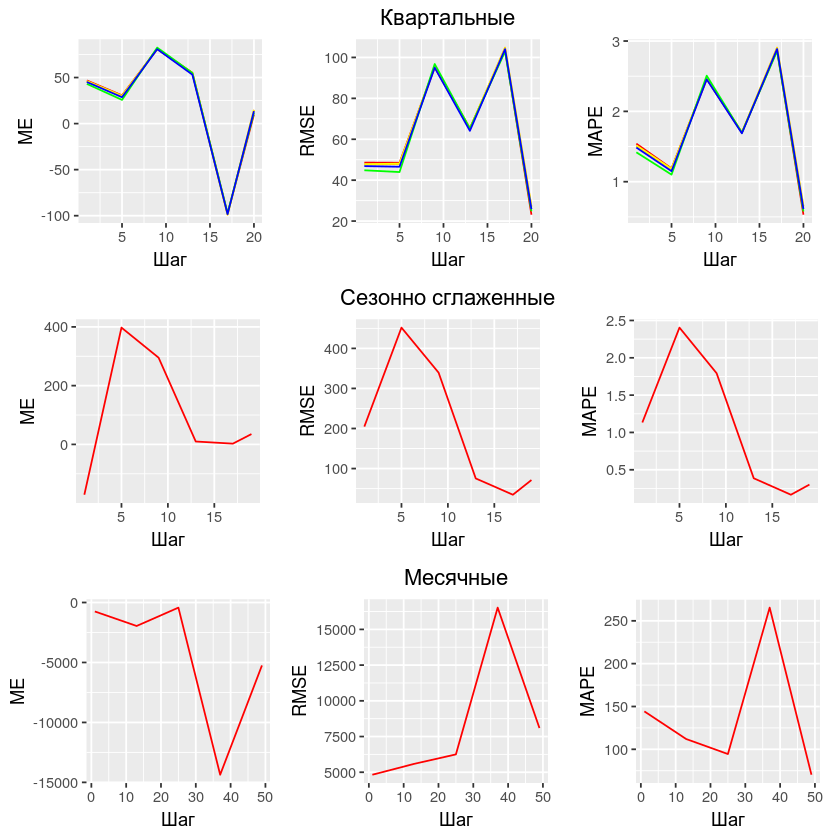

In [64]:
# Basic line plot with points

# plots_test_all <- readRDS("plots_test_not_all.rds")

var_col_test  <-  'blue'
# var_col_train  <-  'red'

for (i in 1:3) {
    
    k = i + 0
    
    if  (i==1) {
        
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=ME), colour = var_col_test, data =  df_acc) 
    
        } else if (i==2) { 
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=RMSE), colour = var_col_test, data =  df_acc) 
        } else if (i==3)  {
        plots_test_all[[k]]  <-  plots_test_all[[k]] + 
geom_line(aes(x=Iteration, y=MAPE), colour = var_col_test, data =  df_acc) 
 
    }        
    }

grid.arrange(grobs = plots_test_all, ncol = 3)

In [65]:
saveRDS(df_mean_acc, "df_mean_acc.rds")

In [66]:
df_mean_acc

,Квартальные,Сезонно сглаженные,Месячные
1 level,64.05969,196.2254,8256.353
3 level,64.63630,NA,NA
2 level (state),64.64086,NA,NA
2 level (type),63.08983,NA,NA
2 level (clusetered),63.74245,NA,NA


In [67]:


saveRDS(plots_test_all, "plots_test_not_all.rds")